<a href="https://colab.research.google.com/github/assalahalla/Django-onlinecourse-final-project/blob/master/GAN_str_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [15]:
# HIDE OUTPUT

!pip install -r "./sample_data/requirements.txt"
!pip install tabgan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl (26.1 MB)
  Using cached category_encoders-2.1.0-py2.py3-none-any.whl (100 kB)
ERROR: Could not find a version that satisfies the requirement numpy==1.22.0 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0rc1, 1.19.0rc2, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0rc1, 1

redémarrez le runtime pour pouvoir utiliser les versions nouvellement installées.

# **Chargement de données**

Nous allons commencer par générer de fausses données. La bibliothèque tabgan peut générer des données catégorielles (textuelles) et continues (numériques).

La bibliothèque tabgan nécessite la trame de données Pandas pour s'entraîner. Pour cette raison, nous conservons les valeurs Pandas et Numpy.

Nous évaluons maintenant le réseau neuronal formé pour voir le RMSE. Nous utiliserons ce réseau de neurones formé pour comparer la précision entre les données d'origine et les données générées par le GAN.

---

Si un réseau de neurones formé sur des données originales ne fonctionne pas bien sur de nouvelles données, alors les nouvelles données peuvent être suspectes ou fausses.


In [16]:
# HIDE OUTPUT
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
import json

# on charge un fichier json "le schéma"
with open('./sample_data/schema.json', 'r') as f :
  datajs = json.load(f)

# on le tronsforme en pandas dataframe 
# car le modèle utilisé n'accepte que des Input sous la forme panda.DataFrame
df = pd.DataFrame(datajs)

# COLS_USED et COLS_TRAIN ont les listes des colonnes utilisées pour la génération de données
# COLS_USED contient une colonne apelé "target colomn" 
# cette dernière sera utilisé pour le training du model
COLS_USED = ['cylinders', 'displacement', 'horsepower', 'weight', 
          'acceleration', 'year', 'origin','mpg']
COLS_TRAIN = ['cylinders', 'displacement', 'horsepower', 'weight', 
          'acceleration', 'year', 'origin']

# df est un dataframe 
# on entraine le modele
df = df[COLS_USED]

# prise en charge de la valeur manquante
# fillna() remplit les valeurs manquantes de la colonne avec la moyenne de la colonne.
#median() renvoie la médiane de la colonne.
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())


# Entrainement et test
  # train_test_split() divise la base de données en deux parties, une pour l'entrainement et une pour le test.  
  # df.drop("mpg", axis=1) est la base de données sans la colonne mpg.
  #df["mpg"] est la colonne mpg. qui est la colonne cible. que l'on va utiliser pour entrainer le modèle.
  # elle contient les valeurs que l'on veut prédire. elle est vide pour le moment.
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df.drop("mpg", axis=1),
    df["mpg"],
    test_size=0.20,
    #shuffle=False,
    random_state=42,
)

# Création des versions dataframe pour GAN
  # df_x_train est le dataframe de données d'entrainement.
  # df_x_test est le dataframe de données de test.
  # df_y_train est le dataframe de données d'entrainement pour la colonne cible.
  # df_y_test est le dataframe de données de test pour la colonne cible.

# rest_index() permet de supprimer les indexs.
# ils sont inutiles pour le modèle après l'entrainement.

df_x_test, df_y_test = df_x_test.reset_index(drop=True), \
  df_y_test.reset_index(drop=True)

# on crée les dataframe
#une fois que les dataframes ont été créés, on peut les utiliser pour entrainer le modèle.

df_y_train = pd.DataFrame(df_y_train)
df_y_test = pd.DataFrame(df_y_test)

# Pandas to Numpy
    # parce que nous allons utiliser les données dans un modèle, nous devons les convertir en tableau Numpy.
    # la différence entre Pandas et Numpy est que Pandas est un dataframe et Numpy est un tableau.
    # le modele de machine learning s'appelle TensorFlow.
x_train = df_x_train.values
x_test = df_x_test.values
y_train = df_y_train.values
y_test = df_y_test.values

# construire le modèle :
model = Sequential()
# Hidden 1


# Dense() crée une couche de neurones.
# input_dim est la dimension de l'entrée.
# la fonction d'activation sert à activer les neurones.
# x_train.shape[1] est la dimension de l'entrée.

model.add(Dense(50, input_dim=x_train.shape[1], activation='relu')) 
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(12, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

# compile est une fonction qui compile le modèle.
# prends en paramètre l'optimiseur, la fonction de coût
model.compile(loss='mean_squared_error', optimizer='adam')

# optimizer est l'optimiseur de la couche de neurones.
# il s'agit d'un algorithme de descente de gradient.
# il s'appelle Adam.

# loss est la fonction de coût.
# loss="mean_squared_error" est la fonction de coût qui est la moyenne des carrés des erreurs.
# la moyenne des carrés des erreurs est une méthode de prédiction basique.
# elle sert à prédire la moyenne des erreurs.

#-----------------------------------------------#

#EarlyStopping est un callback qui permet d'arrêter le modèle si il ne change pas depuis un certain nombre d'itérations.
    # Les paramètres de "EarlyStopping" sont : 
        #  verbose est le niveau de verbosité.
        # verbose=1 permet d'afficher les informations sur l'évolution du modèle.
        # mode='auto' permet d'arrêter le modèle si il ne change pas depuis un certain nombre d'itérations.
        # patience = 5 est le nombre d'itérations avant d'arrêter le modèle.
        # restore_best_weights = True permet de restaurer le modèle avec le meilleur score.
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

#--------------------------------------------------#
# On entraine le modèle :
    #  on applique "fit" qui est une fonction qui entraine le modèle.
    # on lui passe en paramètre :
        # x_train qui est le dataframe de données d'entrainement.
        # y_train qui est le dataframe de données d'entrainement pour la colonne cible.
        # validation_data =(x_test, y_test) qui est le dataframe de données de test.
        # callbacks [monitor] qui est le callback qui permet d'arrêter le modèle si il ne change pas depuis un certain nombre d'itérations.
        # verbose =2 qui est le niveau de verbosité.
        # epoch = 1000 qui est le nombre d'itérations.

model.fit(x_train,y_train,validation_data=(x_test,y_test),
        callbacks=[monitor], verbose=2,epochs=1000)

Epoch 1/1000
10/10 - 1s - loss: 306261.3125 - val_loss: 43262.7305 - 1s/epoch - 107ms/step
Epoch 2/1000
10/10 - 0s - loss: 10292.3154 - val_loss: 9701.2715 - 85ms/epoch - 9ms/step
Epoch 3/1000
10/10 - 0s - loss: 11313.3584 - val_loss: 6210.0273 - 112ms/epoch - 11ms/step
Epoch 4/1000
10/10 - 0s - loss: 2003.8663 - val_loss: 1048.2646 - 78ms/epoch - 8ms/step
Epoch 5/1000
10/10 - 0s - loss: 1667.8605 - val_loss: 1012.7752 - 111ms/epoch - 11ms/step
Epoch 6/1000
10/10 - 0s - loss: 622.3005 - val_loss: 650.8812 - 81ms/epoch - 8ms/step
Epoch 7/1000
10/10 - 0s - loss: 638.4641 - val_loss: 571.0159 - 105ms/epoch - 10ms/step
Epoch 8/1000
10/10 - 0s - loss: 475.0899 - val_loss: 469.1083 - 82ms/epoch - 8ms/step
Epoch 9/1000
10/10 - 0s - loss: 478.7371 - val_loss: 448.4478 - 89ms/epoch - 9ms/step
Epoch 10/1000
10/10 - 0s - loss: 448.9254 - val_loss: 461.7656 - 107ms/epoch - 11ms/step
Epoch 11/1000
10/10 - 0s - loss: 440.8751 - val_loss: 434.3918 - 143ms/epoch - 14ms/step
Epoch 12/1000
10/10 - 0s - 

In [17]:
# pred est le dataframe de données générées par le GAN.
# predict est la fonction qui permet de prédire les données générées par le GAN.
# on lui passe en paramètre :
    # x_test qui est le dataframe de données de test.
pred = model.predict(x_test)

# score est la fonction qui permet de calculer le score.
    # np.sqrt(np.mean(np.square(y_test - pred))) est le score.
    # metrics est la liste des métriques que nous voulons calculer.
    # mean_squared_error est la moyenne des carrés des erreurs.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))

# on affiche le score.
print("Final score (RMSE): {}".format(score))

3/3 [==============================] - 0s 3ms/step
Final score (RMSE): 5.479948563853967


# **Training du GAN**

Ensuite, nous allons entraîner le GAN à générer de fausses données à partir des données d'origine. Il existe de nombreuses options que vous pouvez affiner pour le GAN. L'exemple présenté ici utilise la plupart des valeurs par défaut. Ce sont les hyperparamètres habituels qui doivent être réglés pour n'importe quel modèle et nécessitent une certaine expérimentation pour des résultats optimaux.


**on crée un GAN**
    #  gen_x est la fonction qui permet de générer les données originales 
    #  gen_y est la fonction qui permet de générer les données cibles.

**GanGenerator()** est une classe qui permet de générer des données.
    #  les paramètres sont : 
        # gen_x_times est le nombre de fois que l'on génère les données originales.
        # cat_cols est la liste des colonnes qui contiennent des catégories.
            # cat_cols = None signifie que toutes les colonnes sont des catégories.
        # bot_filter_quantile = 0.001 signifie que seulement 1% des données cibles seront filtrées.
        # top_filter_quantile=0.999 signifie que seulement 99.9% des données cibles seront filtrées.
        # is_post_processed est un booléen qui permet de savoir si les données ont été post-traitements.
        # adversial_model_params est la liste des paramètres du modèle adversaire.
        # pregeneration_frac est le pourcentage de données à générer.
        # only_generated_data = False signifie que les données originales seront aussi générées.
        # gen_params est la liste des paramètres du générateur.
            # bath_size est le nombre de données à générer.
            # patience est le nombre d'itérations avant d'arrêter le modèle.
            # epochs est le nombre d'itérations.
**generate_data_pipe** est la fonction qui permet de générer des données.
            # prends en paramètre :
                # df_x_train qui est le dataframe de données d'entrainement.
                # df_y_train qui est le dataframe de données d'entrainement pour la colonne cible.
                # df_x_test qui est le dataframe de données de test.
                # deep_copy qui est un booléen qui permet de savoir si on doit copier les données.
                # only_advestial_data qui est un booléen qui permet de savoir si on doit générer des données adversaires.
                # use_adversarial_data qui est un booléen qui permet de savoir si on doit utiliser des données adversaires.


In [18]:
# on importe GanGenerator qui est la classe du GAN.
    # tabgan est le GAN.
    # sampler est la fonction qui permet de générer des données.
from tabgan.sampler import GANGenerator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

gen_x, gen_y = GANGenerator(gen_x_times=1.1, cat_cols=None,
           bot_filter_quantile=0.001, top_filter_quantile=0.999, \
              is_post_process=True,
           adversarial_model_params={
               "metrics": "rmse", "max_depth": 2, "max_bin": 100, 
               "learning_rate": 0.02, "random_state": \
                42, "n_estimators": 500,
           }, pregeneration_frac=2, only_generated_data=False,\
           gan_params = {"batch_size": 500, "patience": 25, \
          "epochs" : 500,}).generate_data_pipe(df_x_train, df_y_train,\
          df_x_test, deep_copy=True, only_adversarial=False, \
          use_adversarial=True)



Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]


# **Évaluation des résultats du GAN**

nous pouvons voir que les données générées par le GAN ressemblent à l'original. Certaines valeurs, généralement des nombres entiers dans les données d'origine, ont des valeurs fractionnaires dans les données synthétiques.


In [19]:
# on affiche les données générées par le GAN.
# gen_x est de type pandas.DataFrame.
gen_x

,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,7,110.179176,77.468282,3329,21.368845,81,2
1,7,398.032963,85.790686,3053,20.721977,77,2
2,8,123.853831,70.095233,4382,21.521412,81,2
3,8,296.366660,73.141014,3177,19.904903,73,3
4,6,346.644330,78.809394,4408,17.957497,78,2
...,...,...,...,...,...,...,...
493,8,400.000000,170.000000,4746,12.000000,71,1
494,8,351.000000,153.000000,4154,13.500000,71,1
495,8,318.000000,150.000000,4135,13.500000,72,1
496,8,318.000000,150.000000,4096,13.000000,71,1


In [20]:
# on affiche les données générer sous formats JSON
    # iloc[] nous permet de sélectionner toutes les lignes dans le dataframe gen_x
    # to_json() permet de convertir les données en JSON.
    # orient = "records" signifie que les données seront grouper par ligne.
    # indent = 5 signifie que les données seront visuellemnt plus lisible.
print(gen_x.iloc[:].to_json(orient = "records", indent = 5))

[
     {
          "cylinders":7,
          "displacement":110.179175933,
          "horsepower":77.4682821643,
          "weight":3329,
          "acceleration":21.3688454809,
          "year":81,
          "origin":2
     },
     {
          "cylinders":7,
          "displacement":398.0329626356,
          "horsepower":85.7906863236,
          "weight":3053,
          "acceleration":20.7219769664,
          "year":77,
          "origin":2
     },
     {
          "cylinders":8,
          "displacement":123.8538311409,
          "horsepower":70.0952325663,
          "weight":4382,
          "acceleration":21.5214116593,
          "year":81,
          "origin":2
     },
     {
          "cylinders":8,
          "displacement":296.3666597168,
          "horsepower":73.141013986,
          "weight":3177,
          "acceleration":19.9049032236,
          "year":73,
          "origin":3
     },
     {
          "cylinders":6,
          "displacement":346.644329732,
          "horsepower":7

In [21]:
# on sauvegarde les données générées dans un fichier que l'on nomme "json_gen.json"
gen_x.iloc[:].to_json('json_gen.json', orient="records", indent = 5)

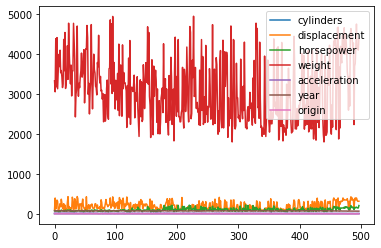

In [22]:
# premier graphe des données générées :
gen_x.plot()

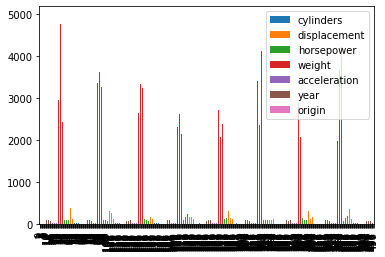

In [23]:
# deuxième graphe des données générées 
gen_x.plot(kind='bar') 

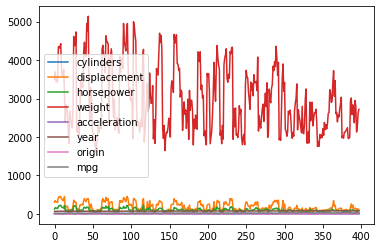

In [24]:
#  premier graphe des données originales
df.plot()

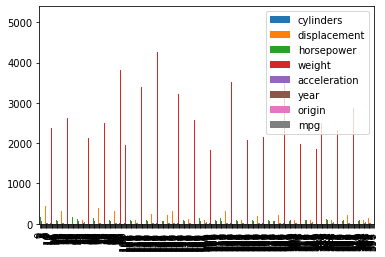

In [12]:
# deuxième graphe des données priginales
df.plot(kind="bar")

In [13]:
# Prediction du modèle
# on définie des fonctions que nous avons utilsé auparavant
    #  pred et score
pred = model.predict(gen_x.values)
score = np.sqrt(metrics.mean_squared_error(pred,gen_y.values))

# on affiche le score du modèle
# score est de type float.
# plus le score est petit, plus le modèle est bon.
# plus le score est grand, plus le modèle est mauvais.

# on affiche le score du modèle
print("Final score (RMSE): {}".format(score))

15/15 [==============================] - 0s 2ms/step
Final score (RMSE): 8.504560189241387
